In [1]:
import os
import pandas as pd
import cv2
import face_recognition
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import imutils
from imutils import paths
import time
import math
import sys
from threading import Timer
import shutil
import time
import seaborn as sns
#Tensor libraries for face/mask recognitions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream


#Tensor and etc libraries to train the models and datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG19, ResNet50, InceptionV3, MobileNet, DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import argparse

In [2]:
from pathlib import Path

cwd = Path().resolve()
# cwd == PosixPath('/path/to/this/jupyter/ipynb/file's/directory/')
cwd

WindowsPath('C:/Users/alrab/OneDrive/Documents/GitHub/Face_Mask_Recog_Project')

In [3]:
#grabing dataset directory path
#grabbing model directory path to save h5 model file
dataset_path=os.getcwd()+"/dataset"
model_path=os.getcwd()+"/model/mask_model"

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 59

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images (With / Without Mask)
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
imagePaths = [imagePath.replace("\\","//",-1) for imagePath in imagePaths]
data = []
labels = []

[INFO] loading images...


In [6]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split("//")[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

C:\Users\alrab\anaconda3\envs\Face_recognition\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
# perform one-hot encoding on the labels
# Converting text labels to readable data to the machine 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42)

In [10]:
# construct the training image generator for data augmentation via the ImageDataGenerator class
# modefying the size of the training dataset to fit the model
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# load the MobileNetV2 network, ensuring the head Fully connected layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [12]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [16]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 213s 2s/step - loss: 0.3314 - accuracy: 0.8858 - val_loss: 0.1215 - val_accuracy: 0.9741
Epoch 2/20
96/96 [==============================] - 222s 2s/step - loss: 0.1158 - accuracy: 0.9691 - val_loss: 0.0749 - val_accuracy: 0.9799
Epoch 3/20
96/96 [==============================] - 214s 2s/step - loss: 0.0812 - accuracy: 0.9770 - val_loss: 0.0605 - val_accuracy: 0.9809
Epoch 4/20
96/96 [==============================] - 200s 2s/step - loss: 0.0630 - accuracy: 0.9815 - val_loss: 0.0575 - val_accuracy: 0.9804
Epoch 5/20
96/96 [==============================] - 210s 2s/step - loss: 0.0601 - accuracy: 0.9836 - val_loss: 0.0479 - val_accuracy: 0.9857
Epoch 6/20
96/96 [==============================] - 212s 2s/step - loss: 0.0517 - accuracy: 0.9832 - val_loss: 0.0451 - val_accuracy: 0.9862
Epoch 7/20
96/96 [==============================] - 220s 2s/step - loss: 0.0491 - accuracy: 0.9846 - val_loss: 0.0434 - val_accura

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
33/33 [==============================] - 31s 773ms/step


In [18]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       932
without_mask       1.00      0.99      0.99       957

    accuracy                           0.99      1889
   macro avg       0.99      0.99      0.99      1889
weighted avg       0.99      0.99      0.99      1889



# 0 - With Mask | 1 - Without Mask

Text(0.5, 25.722222222222214, 'Predicted label')

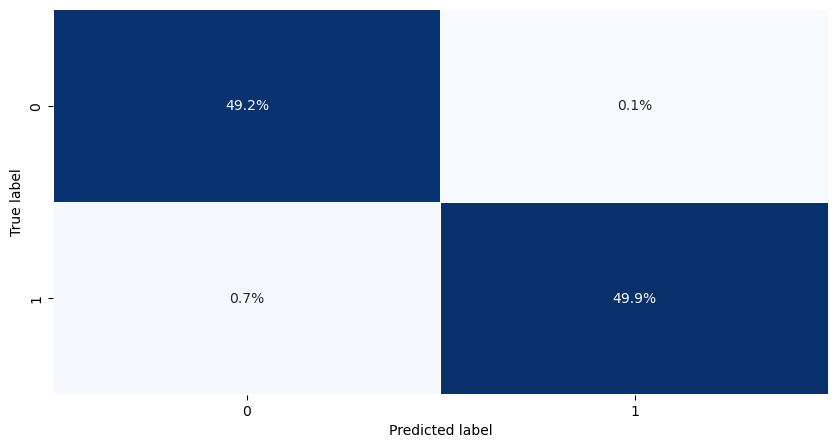

In [20]:
# summary of the number of correct and incorrect predictions made by a classifier.
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)/np.sum(confusion_matrix(testY.argmax(axis=1), predIdxs))
sns.heatmap(cm, annot=True, fmt= '.1%', lw=0.1, cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(model_path+".h5")

[INFO] saving mask detector model...


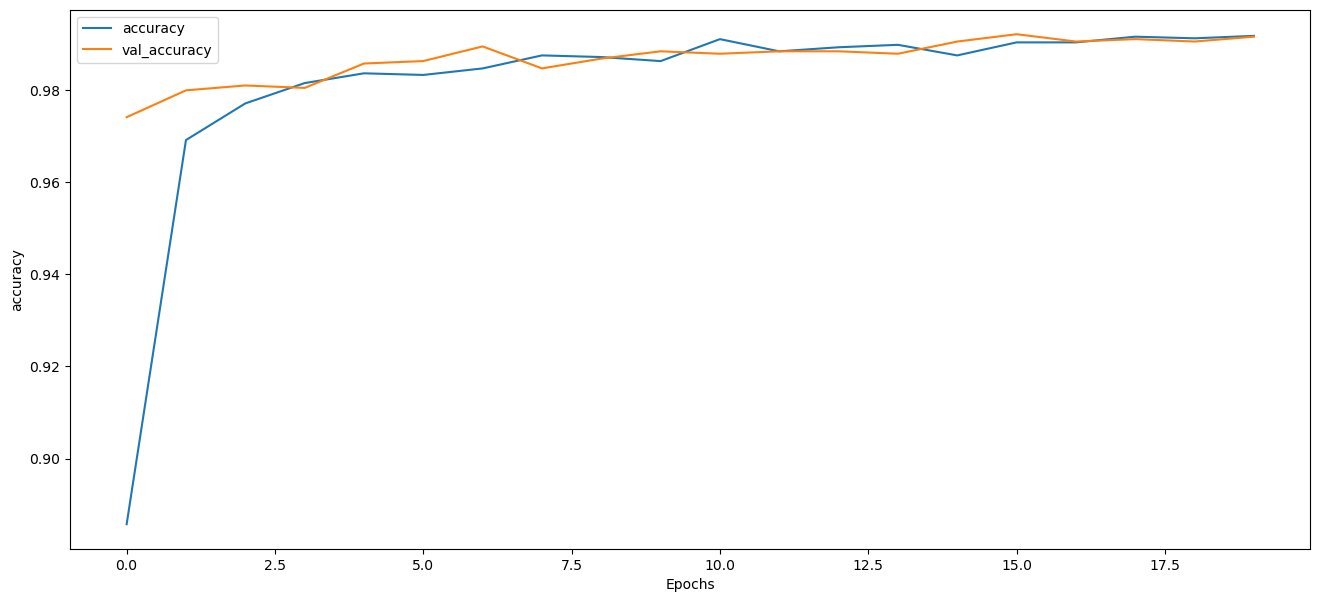

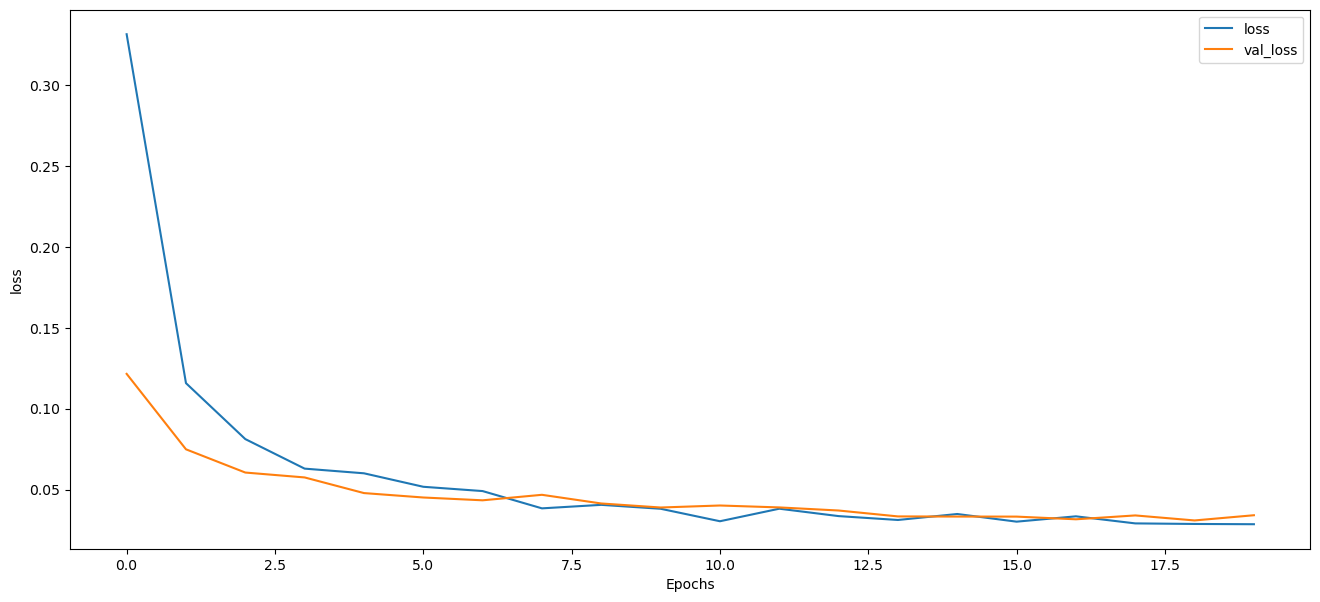

In [22]:
#plot summary of training accuracy/loss and any signs of overfitting on the data
def plot_graph(history,string):
    plt.figure(figsize=(16,7))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label=str(string))
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()


plot_graph(H,"accuracy")
plot_graph(H,"loss")

In [23]:
# A data array of the training loss/Accuracy and validations
H.history

{'loss': [0.3314451575279236,
  0.11579664051532745,
  0.08122121542692184,
  0.06295935809612274,
  0.060075510293245316,
  0.05174453556537628,
  0.04908891022205353,
  0.03841009736061096,
  0.04057542607188225,
  0.03815844655036926,
  0.030444568023085594,
  0.038190968334674835,
  0.033621300011873245,
  0.031224606558680534,
  0.03492069989442825,
  0.03018680214881897,
  0.03348280116915703,
  0.029114283621311188,
  0.028766395524144173,
  0.028603021055459976],
 'accuracy': [0.885769784450531,
  0.9691030979156494,
  0.9770480394363403,
  0.9814618825912476,
  0.9835805296897888,
  0.9832273721694946,
  0.9846398234367371,
  0.9874646663665771,
  0.9871115684509277,
  0.9862288236618042,
  0.9909957647323608,
  0.9883474707603455,
  0.989230215549469,
  0.9897598624229431,
  0.9874646663665771,
  0.990289568901062,
  0.990289568901062,
  0.991525411605835,
  0.9911723136901855,
  0.9917019605636597],
 'val_loss': [0.12153252959251404,
  0.07490243017673492,
  0.06054249778389

In [24]:
# A clean data table of the training loss/Accuracy and validations 
loss_df = pd.DataFrame(H.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.331445,0.885770,0.121533,0.974060
1,0.115797,0.969103,0.074902,0.979884
2,0.081221,0.977048,0.060542,0.980942
3,0.062959,0.981462,0.057518,0.980413
4,0.060076,0.983581,0.047852,0.985707
5,0.051745,0.983227,0.045118,0.986236
6,0.049089,0.984640,0.043383,0.989412
7,0.038410,0.987465,0.046782,0.984648
8,0.040575,0.987112,0.041421,0.986766
9,0.038158,0.986229,0.038931,0.988354


In [25]:
#The Start of the Facial Recognition Application
#The Directory path of the face identification being recognized
img_path = str(cwd) + "//Recog_Train"

In [26]:
#Initialization of face images and face names, known encoding images and names
images = []
class_names = []
encode_list = []
encode_list_cl = []
#myList = os.listdir(img_path)

In [27]:
#Loop over the image paths
for subdir in os.listdir(img_path):
    #Aquire subdirectory where indivitual person images are
    path = img_path + '/' + subdir
    path = path + '/'
    for img in os.listdir(path):
        #Extract the person name and image from the image path subdirectory
        img_pic = path + img
        class_names.append(subdir)
        #Load the person image and convert it from BRG (OpenCV ordering)
        cur_img = cv2.imread(img_pic)
        #To dlib ordering (RGB)
        cur_img = cv2.cvtColor(cur_img , cv2.COLOR_BGR2RGB)
        images.append(cur_img)

In [28]:
#frame: A frame from our stream
#faceNet: The model used to detect where in the image faces are
#maskNet: Our COVID-19 face mask classifier model

def detect_and_predict_mask(frame, faceNet, maskNet,threshold):
	# grab the dimensions of the frame and then construct a blob
	# from it
	global detections 
	(h, w) = frame.shape[:2]
    #Blob from image (image, scalefactor=1.0, size, mean)
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),(104.0, 177.0, 123.0))
	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []
	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence >threshold:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)
            
			# add the face and bounding boxes to their respective
			# lists
			locs.append((startX, startY, endX, endY))
			#print(maskNet.predict(face)[0].tolist())
			preds.append(maskNet.predict(face)[0].tolist())
	return (locs, preds)

In [29]:
# Directory path for face mask model 
MASK_MODEL_PATH=os.getcwd()+"\\model\\mask_model.h5"
#FACE_MODEL_PATH=str(cwd)+"\\masksdetection-master\\face_detector"
#CONFIG_PATH=str(cwd)+"\\masksdetection-master\\face_detector"
THRESHOLD = 0.5

In [30]:
#Library to join the faceNet folder path
from os.path import dirname, join

In [31]:
current_folder = globals()['_dh'][0]
current_folder

'C:\\Users\\alrab\\OneDrive\\Documents\\GitHub\\Face_Mask_Recog_Project'

In [32]:
#Config file for the faceNet model
#The .prototxt file(s) which define the model architecture (i.e., the layers themselves)
protoPath = join(current_folder, "deploy.prototxt")
#The .caffemodel file which contains the weights for the actual layers
weightsPath = join(current_folder, "res10_300x300_ssd_iter_140000.caffemodel")

In [33]:
# load our serialized face detector model from disk
#Single Shot Detector (SSD) framework with a ResNet base network
print("[INFO] loading face detector model...")
faceNet = cv2.dnn.readNet(protoPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(MASK_MODEL_PATH)

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [34]:
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(0).start()
time.sleep(2.0)
        
def find_encodings(images) :
    
        # loop over the face images
        for img in images : 
            
            # compute the facial embedding for the face
            encodings = face_recognition.face_encodings(img)[0]
            
            #add each encoding to our set of encodings
            encode_list.append(encodings)
       
        return encode_list
    
encodeListKnown = find_encodings(images)
 
cap = cv2.VideoCapture(0)

[INFO] starting video stream...


In [ ]:
# loop over the frames from the video stream
while True : 
    #Capturing image from the video stream,then resize and color conversion using openCV libraries 
    success , img = cap.read()
    imgs = cv2.resize(img,(0,0),None,0.25,0.25)
    imgs = cv2.cvtColor(imgs , cv2.COLOR_BGR2RGB)
    
    #Getting the location of the face mask boundaries
    #and the predection of With/Without Mask
    (locs, preds) = detect_and_predict_mask(imgs, faceNet, maskNet,THRESHOLD)
    
    #Getting the location of the face box (the actual boundaries) from the video stream 
    facesCurFrame = face_recognition.face_locations(imgs)
    
    #Getting the face encodings from any faces in the video stram
    encodeCurFrame  = face_recognition.face_encodings(imgs,facesCurFrame)
    
    for encodeFace , faceLoc , pred in zip(encodeCurFrame,facesCurFrame ,preds):
        
        # Obtaining the classification label along with the associated probability
        (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        
        #Color the label Red No Mask,Green with Mask
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        
        #Comparing the face encoding from the video stream to the known list of encodings
        matches = face_recognition.compare_faces(encode_list, encodeFace)
        
        #Get a distance between face encoding from the video stream to the known list of encodings key points.
        #Lower distance means better match
        faceDis = face_recognition.face_distance(encode_list, encodeFace)
        
        #Returns the index of the lowest distance face point and stores it in the matchIndex variable.
        matchIndex = np.argmin(faceDis)
        
        #Grab the element from the class_Names list of the same matching index
        name = class_names[matchIndex]
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
       #Draw a rectangle over the detected faces
        y1,x2,y2,x1 = faceLoc
        y1,x2,y2,x1 = y1*4 , x2*4 , y2*4 , x1*4
        
        #Draw the mask label with the "known" or "unknown" person name below the face
        cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
        cv2.rectangle(img,(x1,y2-35),(x2,y2),color, cv2.FILLED)
        cv2.putText(img, name, (x1+6 , y2 - 6),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2 )
        cv2.putText(img, label, (x1 , y2+10) , cv2.FONT_HERSHEY_COMPLEX , 1 , (255,0,255) , 2)
        
        
        cv2.imshow('Face Mask Recognition Project' , img)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord("q"):
            break
        
cv2.destroyAllWindows()
vs.stop()

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step
